# PCM development notebook

The aim of this notebook is to create a PCM model and train it with a dataset. Some figures that could help to PCM model development are also plotted.

In [1]:
import xarray as xr
import numpy as np

import pyxpcm
from pyxpcm.models import pcm

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

import Plotter
from Plotter import Plotter #new class for plots in pyxpcm

from PIL import Image

import importlib

## User input
***

__Choose dataset__

In [7]:
#### file path ####

# GLOBAL-ANALYSIS-FORECAST-PHY-001-024
#file_path = '/export/home1/agarciaj/datasets/global-analysis-forecast-phy-001-024_1598520725098.nc'

# GLOBAL_REANALYSIS_PHY_001_030
file_path = '/export/home1/agarciaj/datasets/global-reanalysis-phy-001-030-monthly_1601036810235.nc'

# GLOBAL_REANALYSIS_PHY_001_031
#file_path = '/export/home1/agarciaj/datasets/global-reanalysis-phy-001-031-grepv2-monthly_1598972586332.nc'

# GLOBAL_REANALYSIS_BIO_001_029
#file_path = '/export/home1/agarciaj/datasets/global-reanalysis-bio-001-029-monthly_1598524945308.nc'


# time and coordinates dimensions (expecify then here but use a generic name in the rest of the notebook)
time_dim = 'time'
lon_dim = 'longitude'
let_dim = 'latitude'
z_dim = 'depth'
temp_var = 'thetao'

#temp_var = 'fe'

__Model options__

In [8]:
#Choise of z and pcm features (very important to make a good choise) 
z = np.arange(-1.,-2000,-10.)
pcm_features = {'temperature': z}
#pcm_features = {'iron': z}

#classes
K=6

#fit
features_in_ds = {'temperature': temp_var}

__Plot options__

## Get data
***

Open data files

In [9]:
#open data file
ds = xr.open_dataset(file_path)
ds

<xarray.Dataset>
Dimensions:    (depth: 50, latitude: 205, longitude: 577, time: 12)
Coordinates:
  * depth      (depth) float32 0.494025 1.541375 2.645669 ... 5274.784 5727.917
  * latitude   (latitude) float32 30.0 30.083334 30.166666 ... 46.916668 47.0
  * time       (time) datetime64[ns] 2018-01-16T12:00:00 ... 2018-12-16T12:00:00
  * longitude  (longitude) float32 -6.0 -5.9166665 -5.8333335 ... 41.916668 42.0
Data variables:
    mlotst     (time, latitude, longitude) float32 ...
    vo         (time, depth, latitude, longitude) float32 ...
    thetao     (time, depth, latitude, longitude) float32 ...
    uo         (time, depth, latitude, longitude) float32 ...
    bottomT    (time, latitude, longitude) float32 ...
    so         (time, depth, latitude, longitude) float32 ...
    zos        (time, latitude, longitude) float32 ...
Attributes:
    title:                         Monthly mean fields for product GLOBAL_REA...
    references:                    http://marine.copernicus.eu
    credit:                        E.U. Copernicus Marine Service Information...
    licence:                       http://marine.copernicus.eu/services-portf...
    contact:                       servicedesk.cmems@mercator-ocean.eu
    producer:                      CMEMS - Global Monitoring and Forecasting ...
    institution:                   Mercator Ocean
    Conventions:                   CF-1.6
    area:                          GLOBAL
    product:                       GLOBAL_REANALYSIS_001_030
    dataset:                       global-reanalysis-001-030-monthly
    source:                        MERCATOR GLORYS12V1
    product_user_manual:           http://marine.copernicus.eu/documents/PUM/...
    quality_information_document:  http://marine.copernicus.eu/documents/QUID...
    _CoordSysBuilder:              ucar.nc2.dataset.conv.CF1Convention
    comment:                       
    history:                       Data extracted from dataset http://localho...

Depth values should be negative

In [10]:
#at = ds['depth'].attrs
#ds.assign_coords(depth=-np.abs(ds['depth'].values), keep_attrs=True)
ds['depth'] = -np.abs(ds['depth'].values)
#ds['depth'].attrs.update(at) # not working

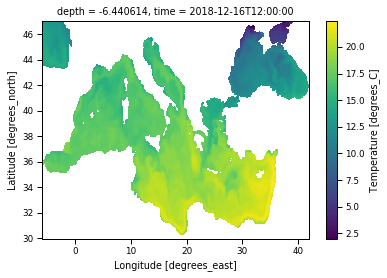

In [11]:
#ds['thetao'].isel(depth=5).plot();
ds[temp_var].isel(time=11, depth=5).plot();
#ds['o2'].isel(time=11, depth=5).plot();
#ds['fe'].isel(time=11, depth=5).plot();

In [12]:
ds.depth.attrs['axis'] = 'Z'
ds

<xarray.Dataset>
Dimensions:    (depth: 50, latitude: 205, longitude: 577, time: 12)
Coordinates:
  * depth      (depth) float32 -0.494025 -1.541375 ... -5274.784 -5727.917
  * latitude   (latitude) float32 30.0 30.083334 30.166666 ... 46.916668 47.0
  * time       (time) datetime64[ns] 2018-01-16T12:00:00 ... 2018-12-16T12:00:00
  * longitude  (longitude) float32 -6.0 -5.9166665 -5.8333335 ... 41.916668 42.0
Data variables:
    mlotst     (time, latitude, longitude) float32 ...
    vo         (time, depth, latitude, longitude) float32 ...
    thetao     (time, depth, latitude, longitude) float32 ...
    uo         (time, depth, latitude, longitude) float32 ...
    bottomT    (time, latitude, longitude) float32 ...
    so         (time, depth, latitude, longitude) float32 ...
    zos        (time, latitude, longitude) float32 ...
Attributes:
    title:                         Monthly mean fields for product GLOBAL_REA...
    references:                    http://marine.copernicus.eu
    credit:                        E.U. Copernicus Marine Service Information...
    licence:                       http://marine.copernicus.eu/services-portf...
    contact:                       servicedesk.cmems@mercator-ocean.eu
    producer:                      CMEMS - Global Monitoring and Forecasting ...
    institution:                   Mercator Ocean
    Conventions:                   CF-1.6
    area:                          GLOBAL
    product:                       GLOBAL_REANALYSIS_001_030
    dataset:                       global-reanalysis-001-030-monthly
    source:                        MERCATOR GLORYS12V1
    product_user_manual:           http://marine.copernicus.eu/documents/PUM/...
    quality_information_document:  http://marine.copernicus.eu/documents/QUID...
    _CoordSysBuilder:              ucar.nc2.dataset.conv.CF1Convention
    comment:                       
    history:                       Data extracted from dataset http://localho...

## Applying PCM
***

### Create PCM

In [13]:
#z choise
z = ds['depth'][0:20]
pcm_features = {'temperature': z}
#pcm_features = {'iron': z}

m = pcm(K=K, features=pcm_features)
m

<pcm 'gmm' (K: 6, F: 1)>
Number of class: 6
Number of feature: 1
Feature names: odict_keys(['temperature'])
Fitted: False
Feature: 'temperature'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing._data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition._pca.PCA'>
Classifier: 'gmm', <class 'sklearn.mixture._gaussian_mixture.GaussianMixture'>

### Fit Model

In [14]:
features_in_ds = {'temperature': temp_var}
#features_in_ds = {'iron': temp_var}
features_zdim=z_dim
m.fit(ds, features=features_in_ds, dim=features_zdim)
m

<pcm 'gmm' (K: 6, F: 1)>
Number of class: 6
Number of feature: 1
Feature names: odict_keys(['temperature'])
Fitted: True
Feature: 'temperature'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing._data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition._pca.PCA'>
Classifier: 'gmm', <class 'sklearn.mixture._gaussian_mixture.GaussianMixture'>
	 log likelihood of the training set: 42.685806

## Development plots
***

__Scatter plot of features, as seen by the classifier__

__TODO__: Plot only first dimension for each feature

In [ ]:
g = m.plot.preprocessed(ds, features=features_in_ds, style='darkgrid', dim='depth')

In [ ]:
g = m.plot.preprocessed(ds, features=features_in_ds, kde=True, dim='depth')

__Mask__

In [ ]:
mask = ds.isel(time=7).pyxpcm.mask(m, features=features_in_ds, dim=features_zdim)
mask.plot()

__BIC__

In [ ]:
m.bic(ds, features=features_in_ds, dim=features_zdim)

In [17]:
import time
start = time.time()

dsp = ds.isel(time=0)

# Since we have more observations than the maximum independant sample size, 
# we can run several BIC computations
kmax = 20
#Nrun = 1
Nrun = 10
BIC = np.zeros((kmax,Nrun))
BICf = np.zeros((kmax,Nrun))

#print(Xn.shape[0])
#n = Xn.shape[0] # Nb of samples
n = 500000 # Nb of independant samples

for run in range(Nrun):
    for k in range(kmax):
        print(k)
        #random sample
        #ii = np.random.choice(range(X.shape[0]), n, replace=False)
        #create model
        m = pcm(K=k+1, features=pcm_features)
        #fit model
        m.fit(dsp, features=features_in_ds, dim=features_zdim)
        #calculate BIC
        
        #this_gmm = GMM(n_components=k+1).fit(Xn[ii])
        BIC[k,run] = m.bic(dsp, features=features_in_ds, dim=features_zdim)
        D = 1 # Nb of dimension
        #Nf = (k+1)-1 + (k+1)*D + (k+1)*D*(D+1)/2 # Nb of independant parameters to estimate
        #print(Nf, m._n_parameters())
        #BICf[k,run] = -2*n*m.score(ds) + Nf*np.log(n)
        
end = time.time()
print(end - start)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
6003.367134094238


In [19]:
6003.367134094238/60/60

1.667601981692844

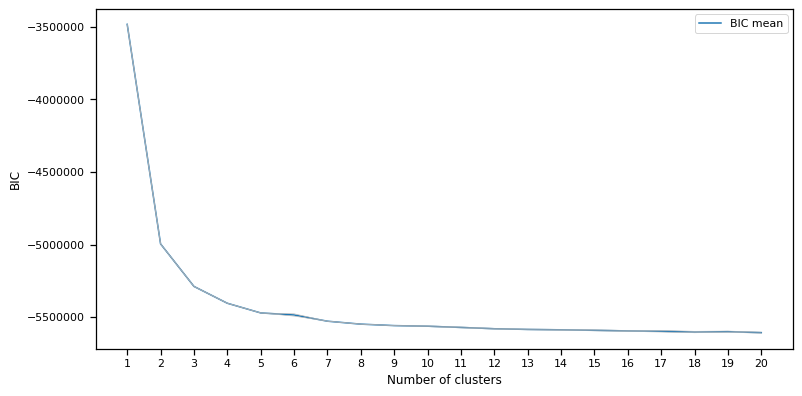

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5), dpi=90)
BICmean = np.mean(BIC,axis=1)
BICstd = np.std(BIC,axis=1)
normBICmean = (BICmean-np.mean(BICmean))/np.std(BICmean)
#plt.plot(np.arange(kmax)+1,(BIC-np.mean(BIC))/np.std(BIC),label='Raw BIC')
plt.plot(np.arange(kmax)+1,BICmean,label='BIC mean')
plt.plot(np.arange(kmax)+1,BICmean+BICstd,color=[0.7]*3,linewidth=0.5)
plt.plot(np.arange(kmax)+1,BICmean-BICstd,color=[0.7]*3,linewidth=0.5)
plt.ylabel('BIC')
plt.xlabel('Number of clusters')
plt.xticks(np.arange(kmax)+1)
plt.legend()

In [21]:
BICstd

array([0.00000000e+00, 6.66660990e-06, 1.22082499e-04, 4.32031338e-03,
       5.03720117e-03, 7.91531072e+03, 1.21629577e-02, 1.25327556e+01,
       9.86393827e+02, 2.76964771e+03, 3.26346586e+03, 2.72893711e+03,
       2.61483027e+03, 3.25529202e+03, 3.53298462e+03, 3.20587891e+03,
       5.10991369e+03, 4.90766507e+03, 4.01019889e+03, 3.67410305e+03])

## Save fitted model
***

In [ ]:
# save model to development
#m.to_netcdf('models/tests_model_GLOBAL_REANALYSIS_PHY_001_030_temp.nc')